# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
bash: ../xvfb: No such file or directory
env: DISPLAY=:1


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-11-04 19:59:35,466] Making new env: LunarLander-v2


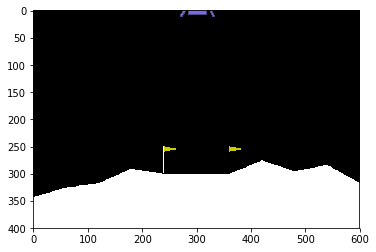

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 200, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn, num_units=n_actions,
                           nonlinearity=None, name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-11-04 19:59:37,359] Making new env: LunarLander-v2


In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 0]]
rewards: [[-2.37986236 -2.85301104 -2.96386651 -3.18009665  0.        ]]
CPU times: user 4.67 ms, sys: 2.15 ms, total: 6.83 ms
Wall time: 5.49 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-11-04 19:59:41,624] Making new env: LunarLander-v2
[2017-11-04 19:59:41,636] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-11-04 19:59:41,651] Starting new video recorder writing to /Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records/openaigym.video.0.14424.video000000.mp4
[2017-11-04 19:59:42,787] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 50 timesteps with reward=-355.63497453329796


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

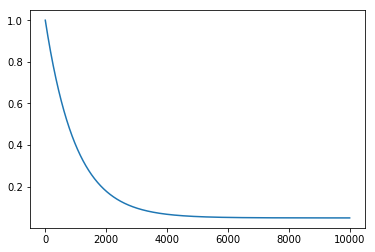

In [23]:
epoch_counter = np.arange(10000)
plt.plot(epoch_counter, 0.05 + 0.95*np.exp(-(epoch_counter)/1000.))
plt.show()

In [17]:
x = []
y = []
epsilon = 0.99
for i in range(10000):
    epsilon = 0.01*np.exp(-i/10000.)
    x.append(i)
    y.append(epsilon)

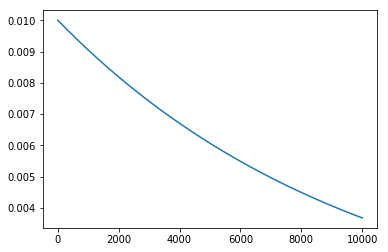

In [18]:
plt.plot(x, y)
plt.show()

In [19]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [20]:
from tqdm import trange
coef = 1.

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = (0.05 + 0.95*np.exp(-epoch_counter/1000.)) * coef
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        if -200 < rewards[epoch_counter] and rewards[epoch_counter] <= -150:
            coef = 0.9
        elif -150 < rewards[epoch_counter] and rewards[epoch_counter] <= -100:
            coef = 0.8
        elif -100 < rewards[epoch_counter] and rewards[epoch_counter] <= -80:
            coef = 0.7
        elif -80 < rewards[epoch_counter]:
            coef = 0.5
        elif -200 >= rewards[epoch_counter]:
            coef = 1.
            
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 97/10000 [00:03<08:03, 20.49it/s][2017-11-04 19:59:47,327] Making new env: LunarLander-v2
[2017-11-04 19:59:47,335] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-11-04 19:59:47,501] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  1%|          | 100/10000 [00:04<10:43, 15.38it/s]

Episode finished after 68 timesteps with reward=-256.9460906441907
Episode finished after 114 timesteps with reward=-180.74317941949
Episode finished after 80 timesteps with reward=-269.26874560938506
iter=100	epsilon=0.910
Current score(mean over 3) = -235.653


  2%|▏         | 198/10000 [00:08<06:23, 25.53it/s][2017-11-04 19:59:51,509] Making new env: LunarLander-v2
[2017-11-04 19:59:51,519] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:59:51,792] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  2%|▏         | 201/10000 [00:08<11:15, 14.51it/s]

Episode finished after 157 timesteps with reward=-324.3316729764223
Episode finished after 113 timesteps with reward=-574.0128905385681
Episode finished after 139 timesteps with reward=-246.5362115358651
iter=200	epsilon=0.828
Current score(mean over 3) = -381.627


  3%|▎         | 297/10000 [00:12<06:39, 24.30it/s][2017-11-04 19:59:56,158] Making new env: LunarLander-v2
[2017-11-04 19:59:56,166] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 19:59:56,304] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  3%|▎         | 300/10000 [00:13<08:59, 17.97it/s]

Episode finished after 100 timesteps with reward=-190.74847400685877
Episode finished after 84 timesteps with reward=-96.6296303033353
Episode finished after 129 timesteps with reward=-263.1758693344024
iter=300	epsilon=0.754
Current score(mean over 3) = -183.518


  4%|▍         | 399/10000 [00:17<06:27, 24.77it/s][2017-11-04 20:00:00,564] Making new env: LunarLander-v2
[2017-11-04 20:00:00,572] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:00,809] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 106 timesteps with reward=-380.44895953782805
Episode finished after 170 timesteps with reward=-284.86356269168573
Episode finished after 193 timesteps with reward=-419.6304887166367
iter=400	epsilon=0.618
Current score(mean over 3) = -361.648


  5%|▍         | 498/10000 [00:21<07:54, 20.04it/s][2017-11-04 20:00:05,219] Making new env: LunarLander-v2
[2017-11-04 20:00:05,227] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:05,478] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  5%|▌         | 501/10000 [00:22<11:43, 13.49it/s]

Episode finished after 205 timesteps with reward=-455.79518475244106
Episode finished after 143 timesteps with reward=-455.3496657600757
Episode finished after 151 timesteps with reward=-470.1665211707955
iter=500	epsilon=0.564
Current score(mean over 3) = -460.437


  6%|▌         | 598/10000 [00:26<06:40, 23.48it/s][2017-11-04 20:00:09,872] Making new env: LunarLander-v2
[2017-11-04 20:00:09,881] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:10,041] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  6%|▌         | 601/10000 [00:26<09:31, 16.44it/s]

Episode finished after 145 timesteps with reward=-370.98582297759685
Episode finished after 82 timesteps with reward=-357.947100716032
Episode finished after 114 timesteps with reward=-350.0727163902948
iter=600	epsilon=0.514
Current score(mean over 3) = -359.669


  7%|▋         | 699/10000 [00:32<23:07,  6.70it/s][2017-11-04 20:00:16,009] Making new env: LunarLander-v2
[2017-11-04 20:00:16,018] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:16,288] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  7%|▋         | 700/10000 [00:33<31:20,  4.95it/s]

Episode finished after 227 timesteps with reward=-540.7108154953032
Episode finished after 156 timesteps with reward=-286.00824923571224
Episode finished after 148 timesteps with reward=-247.64018310820552
iter=700	epsilon=0.470
Current score(mean over 3) = -358.120


  8%|▊         | 797/10000 [00:37<08:58, 17.09it/s][2017-11-04 20:00:21,401] Making new env: LunarLander-v2
[2017-11-04 20:00:21,410] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:21,556] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
  8%|▊         | 800/10000 [00:38<10:45, 14.25it/s]

Episode finished after 80 timesteps with reward=-370.4433523046598
Episode finished after 148 timesteps with reward=-576.7443176143436
Episode finished after 85 timesteps with reward=-326.8463057000368
iter=800	epsilon=0.429
Current score(mean over 3) = -424.678


  9%|▉         | 899/10000 [00:43<08:08, 18.65it/s][2017-11-04 20:00:26,700] Making new env: LunarLander-v2
[2017-11-04 20:00:26,707] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:26,934] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 89 timesteps with reward=-278.0737279135576
Episode finished after 159 timesteps with reward=-498.9229410044648
Episode finished after 203 timesteps with reward=-824.7054411078559
iter=900	epsilon=0.393
Current score(mean over 3) = -533.901


 10%|▉         | 997/10000 [00:48<06:57, 21.57it/s][2017-11-04 20:00:31,926] Making new env: LunarLander-v2
[2017-11-04 20:00:31,933] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:32,092] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 10%|█         | 1002/10000 [00:48<08:53, 16.86it/s]

Episode finished after 124 timesteps with reward=-275.9637907307225
Episode finished after 100 timesteps with reward=-529.3664346634332
Episode finished after 126 timesteps with reward=-414.5838849051676
iter=1000	epsilon=0.360
Current score(mean over 3) = -406.638


 11%|█         | 1097/10000 [00:53<07:41, 19.27it/s][2017-11-04 20:00:37,294] Making new env: LunarLander-v2
[2017-11-04 20:00:37,301] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:37,550] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 11%|█         | 1100/10000 [00:54<11:22, 13.05it/s]

Episode finished after 111 timesteps with reward=-444.70665581195624
Episode finished after 152 timesteps with reward=-465.2947971471403
Episode finished after 227 timesteps with reward=-855.6788912049008
iter=1100	epsilon=0.330
Current score(mean over 3) = -588.560


 12%|█▏        | 1199/10000 [01:00<09:10, 15.98it/s][2017-11-04 20:00:43,463] Making new env: LunarLander-v2
[2017-11-04 20:00:43,472] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:00:43,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 131 timesteps with reward=-576.356798009992
Episode finished after 132 timesteps with reward=-340.36351144674086
Episode finished after 202 timesteps with reward=-415.3162121521433
iter=1200	epsilon=0.303
Current score(mean over 3) = -444.012


 13%|█▎        | 1299/10000 [01:06<08:03, 17.98it/s][2017-11-04 20:00:49,571] Making new env: LunarLander-v2
[2017-11-04 20:00:49,580] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 169 timesteps with reward=-355.4178338135514
Episode finished after 251 timesteps with reward=-312.56074402302283


[2017-11-04 20:00:49,985] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 13%|█▎        | 1303/10000 [01:06<14:07, 10.27it/s]

Episode finished after 293 timesteps with reward=-321.0941114184742
iter=1300	epsilon=0.278
Current score(mean over 3) = -329.691


 14%|█▍        | 1399/10000 [01:12<09:02, 15.85it/s][2017-11-04 20:00:55,954] Making new env: LunarLander-v2
[2017-11-04 20:00:55,963] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 209 timesteps with reward=-251.37390239542333
Episode finished after 278 timesteps with reward=-406.8567607312524


[2017-11-04 20:00:56,402] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 14%|█▍        | 1401/10000 [01:13<18:50,  7.60it/s]

Episode finished after 240 timesteps with reward=-317.20085262771653
iter=1400	epsilon=0.256
Current score(mean over 3) = -325.144


 15%|█▍        | 1499/10000 [01:19<09:02, 15.68it/s][2017-11-04 20:01:03,040] Making new env: LunarLander-v2
[2017-11-04 20:01:03,048] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 160 timesteps with reward=-329.0600752603963
Episode finished after 196 timesteps with reward=-510.7551564340235


[2017-11-04 20:01:03,338] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 15%|█▌        | 1503/10000 [01:20<13:16, 10.67it/s]

Episode finished after 197 timesteps with reward=-677.8557901926594
iter=1500	epsilon=0.236
Current score(mean over 3) = -505.890


 16%|█▌        | 1599/10000 [01:26<10:28, 13.37it/s][2017-11-04 20:01:10,163] Making new env: LunarLander-v2
[2017-11-04 20:01:10,171] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 249 timesteps with reward=-560.7518972341376


[2017-11-04 20:01:10,932] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 16%|█▌        | 1601/10000 [01:27<26:15,  5.33it/s]

Episode finished after 539 timesteps with reward=-383.80342942764605
Episode finished after 217 timesteps with reward=-580.1534140826778
iter=1600	epsilon=0.218
Current score(mean over 3) = -508.236


 17%|█▋        | 1699/10000 [01:35<10:20, 13.38it/s][2017-11-04 20:01:18,475] Making new env: LunarLander-v2
[2017-11-04 20:01:18,483] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:01:18,739] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 147 timesteps with reward=-271.4084986273964
Episode finished after 214 timesteps with reward=-309.10500819965523
Episode finished after 139 timesteps with reward=-333.16729965304194
iter=1700	epsilon=0.201
Current score(mean over 3) = -304.560


 18%|█▊        | 1798/10000 [01:44<10:27, 13.06it/s][2017-11-04 20:01:27,562] Making new env: LunarLander-v2
[2017-11-04 20:01:27,570] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 268 timesteps with reward=-415.16592428828875


[2017-11-04 20:01:28,185] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 18%|█▊        | 1800/10000 [01:44<24:13,  5.64it/s]

Episode finished after 316 timesteps with reward=-251.97084565580383
Episode finished after 294 timesteps with reward=-609.7891832167743
iter=1800	epsilon=0.186
Current score(mean over 3) = -425.642


 19%|█▉        | 1898/10000 [01:52<10:29, 12.86it/s][2017-11-04 20:01:36,161] Making new env: LunarLander-v2
[2017-11-04 20:01:36,168] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 243 timesteps with reward=-624.2878361670262
Episode finished after 247 timesteps with reward=-627.0751335524564


[2017-11-04 20:01:36,902] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 19%|█▉        | 1902/10000 [01:53<21:38,  6.23it/s]

Episode finished after 384 timesteps with reward=-218.80425833928854
iter=1900	epsilon=0.173
Current score(mean over 3) = -490.056


 20%|█▉        | 1999/10000 [02:01<11:14, 11.87it/s][2017-11-04 20:01:45,297] Making new env: LunarLander-v2
[2017-11-04 20:01:45,305] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 263 timesteps with reward=-602.5386731532365
Episode finished after 127 timesteps with reward=-427.2181027916242


[2017-11-04 20:01:45,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 20%|██        | 2001/10000 [02:02<18:39,  7.15it/s]

Episode finished after 255 timesteps with reward=-555.1016139104061
iter=2000	epsilon=0.161
Current score(mean over 3) = -528.286


 21%|██        | 2099/10000 [02:09<09:27, 13.92it/s][2017-11-04 20:01:52,876] Making new env: LunarLander-v2
[2017-11-04 20:01:52,884] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 239 timesteps with reward=-514.6983876443562
Episode finished after 185 timesteps with reward=-225.69357627458925


[2017-11-04 20:01:53,369] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 21%|██        | 2101/10000 [02:10<20:19,  6.48it/s]

Episode finished after 309 timesteps with reward=-359.7623952404146
iter=2100	epsilon=0.150
Current score(mean over 3) = -366.718


 22%|██▏       | 2199/10000 [02:19<10:46, 12.06it/s][2017-11-04 20:02:02,559] Making new env: LunarLander-v2
[2017-11-04 20:02:02,568] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 205 timesteps with reward=-635.1176976378965


[2017-11-04 20:02:03,980] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 860 timesteps with reward=-568.0895144064698
Episode finished after 258 timesteps with reward=-633.4582242081966
iter=2200	epsilon=0.140
Current score(mean over 3) = -612.222


 23%|██▎       | 2299/10000 [02:29<10:20, 12.42it/s][2017-11-04 20:02:12,752] Making new env: LunarLander-v2
[2017-11-04 20:02:12,760] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 154 timesteps with reward=-385.154247667095


[2017-11-04 20:02:13,309] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 408 timesteps with reward=-295.2611142700324
Episode finished after 232 timesteps with reward=-376.5176184633252
iter=2300	epsilon=0.131
Current score(mean over 3) = -352.311


 24%|██▍       | 2399/10000 [02:37<11:32, 10.98it/s][2017-11-04 20:02:21,312] Making new env: LunarLander-v2
[2017-11-04 20:02:21,322] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 117 timesteps with reward=-313.72413042892026
Episode finished after 105 timesteps with reward=-373.0849891685376


[2017-11-04 20:02:21,725] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 24%|██▍       | 2401/10000 [02:38<18:49,  6.73it/s]

Episode finished after 373 timesteps with reward=-463.5965036032527
iter=2400	epsilon=0.123
Current score(mean over 3) = -383.469


 25%|██▍       | 2499/10000 [02:46<09:34, 13.07it/s][2017-11-04 20:02:29,622] Making new env: LunarLander-v2
[2017-11-04 20:02:29,631] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 207 timesteps with reward=-278.5293067818262


[2017-11-04 20:02:30,163] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 25%|██▌       | 2501/10000 [02:46<19:43,  6.34it/s]

Episode finished after 377 timesteps with reward=-551.305793412117
Episode finished after 182 timesteps with reward=-462.3749711220462
iter=2500	epsilon=0.115
Current score(mean over 3) = -430.737


 26%|██▌       | 2598/10000 [02:54<08:45, 14.07it/s][2017-11-04 20:02:38,232] Making new env: LunarLander-v2
[2017-11-04 20:02:38,240] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 319 timesteps with reward=-464.28338910287647
Episode finished after 326 timesteps with reward=-502.8952204387899


[2017-11-04 20:02:38,997] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 26%|██▌       | 2602/10000 [02:55<19:50,  6.21it/s]

Episode finished after 357 timesteps with reward=-405.89594355369593
iter=2600	epsilon=0.109
Current score(mean over 3) = -457.692


 27%|██▋       | 2698/10000 [03:03<09:25, 12.90it/s][2017-11-04 20:02:47,147] Making new env: LunarLander-v2
[2017-11-04 20:02:47,154] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 301 timesteps with reward=-447.0983461858413
Episode finished after 178 timesteps with reward=-217.48499304452076


[2017-11-04 20:02:47,736] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 27%|██▋       | 2702/10000 [03:04<17:25,  6.98it/s]

Episode finished after 319 timesteps with reward=-488.13830815145025
iter=2700	epsilon=0.102
Current score(mean over 3) = -384.241


 28%|██▊       | 2798/10000 [03:11<08:28, 14.17it/s][2017-11-04 20:02:55,176] Making new env: LunarLander-v2
[2017-11-04 20:02:55,184] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:02:55,486] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 28%|██▊       | 2800/10000 [03:12<14:41,  8.17it/s]

Episode finished after 224 timesteps with reward=-158.33044087063757
Episode finished after 91 timesteps with reward=-347.1464194975391
Episode finished after 208 timesteps with reward=-188.80019117951497
iter=2800	epsilon=0.097
Current score(mean over 3) = -231.426


 29%|██▉       | 2898/10000 [03:19<08:25, 14.05it/s][2017-11-04 20:03:02,815] Making new env: LunarLander-v2
[2017-11-04 20:03:02,824] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:03:03,028] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 29%|██▉       | 2900/10000 [03:19<11:59,  9.87it/s]

Episode finished after 195 timesteps with reward=-170.95478482709171
Episode finished after 118 timesteps with reward=-321.44424022003943
Episode finished after 85 timesteps with reward=-844.0000587718531
iter=2900	epsilon=0.092
Current score(mean over 3) = -445.466


 30%|██▉       | 2998/10000 [03:26<08:15, 14.14it/s][2017-11-04 20:03:09,918] Making new env: LunarLander-v2
[2017-11-04 20:03:09,925] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:03:10,130] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 30%|███       | 3000/10000 [03:26<11:47,  9.90it/s]

Episode finished after 165 timesteps with reward=-596.8270806546725
Episode finished after 78 timesteps with reward=-624.5373707835711
Episode finished after 197 timesteps with reward=-639.3407347112079
iter=3000	epsilon=0.088
Current score(mean over 3) = -620.235


 31%|███       | 3098/10000 [03:33<07:48, 14.72it/s][2017-11-04 20:03:17,202] Making new env: LunarLander-v2
[2017-11-04 20:03:17,211] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:03:17,434] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 31%|███       | 3100/10000 [03:34<12:08,  9.48it/s]

Episode finished after 188 timesteps with reward=-324.32388100846015
Episode finished after 80 timesteps with reward=-566.3790404540516
Episode finished after 183 timesteps with reward=-414.8361973591426
iter=3100	epsilon=0.084
Current score(mean over 3) = -435.180


 32%|███▏      | 3198/10000 [03:41<08:43, 13.00it/s][2017-11-04 20:03:24,973] Making new env: LunarLander-v2
[2017-11-04 20:03:24,981] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 250 timesteps with reward=-466.3184486652933
Episode finished after 284 timesteps with reward=-248.17658613224444


[2017-11-04 20:03:25,524] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 32%|███▏      | 3202/10000 [03:42<15:11,  7.46it/s]

Episode finished after 299 timesteps with reward=-537.3241696809232
iter=3200	epsilon=0.080
Current score(mean over 3) = -417.273


 33%|███▎      | 3298/10000 [03:50<08:14, 13.55it/s][2017-11-04 20:03:33,603] Making new env: LunarLander-v2
[2017-11-04 20:03:33,611] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 402 timesteps with reward=-498.63783960449666
Episode finished after 306 timesteps with reward=-351.01501654289757

[2017-11-04 20:03:34,445] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 33%|███▎      | 3302/10000 [03:51<18:37,  5.99it/s]


Episode finished after 321 timesteps with reward=-252.75501806668035
iter=3300	epsilon=0.077
Current score(mean over 3) = -367.469


 34%|███▍      | 3399/10000 [03:59<08:56, 12.30it/s][2017-11-04 20:03:42,791] Making new env: LunarLander-v2
[2017-11-04 20:03:42,798] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 480 timesteps with reward=-459.4930049431382
Episode finished after 539 timesteps with reward=-259.78479282765187


[2017-11-04 20:03:44,054] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 34%|███▍      | 3401/10000 [04:00<30:03,  3.66it/s]

Episode finished after 308 timesteps with reward=-167.77736565560565
iter=3400	epsilon=0.074
Current score(mean over 3) = -295.685


 35%|███▍      | 3498/10000 [04:08<08:04, 13.41it/s][2017-11-04 20:03:52,292] Making new env: LunarLander-v2
[2017-11-04 20:03:52,299] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 283 timesteps with reward=-228.24297872616006
Episode finished after 271 timesteps with reward=-345.915683132698


[2017-11-04 20:03:52,876] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 35%|███▌      | 3502/10000 [04:09<15:40,  6.91it/s]

Episode finished after 292 timesteps with reward=-332.1089762739866
iter=3500	epsilon=0.071
Current score(mean over 3) = -302.089


 36%|███▌      | 3599/10000 [04:18<09:36, 11.10it/s][2017-11-04 20:04:01,496] Making new env: LunarLander-v2
[2017-11-04 20:04:01,504] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 197 timesteps with reward=-288.03699393072156
Episode finished after 352 timesteps with reward=-230.46087443296432


[2017-11-04 20:04:02,209] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 36%|███▌      | 3601/10000 [04:19<20:46,  5.13it/s]

Episode finished after 375 timesteps with reward=-400.7116016642347
iter=3600	epsilon=0.068
Current score(mean over 3) = -306.403


 37%|███▋      | 3699/10000 [04:26<08:07, 12.91it/s][2017-11-04 20:04:10,251] Making new env: LunarLander-v2
[2017-11-04 20:04:10,259] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 363 timesteps with reward=-408.7569896443573


[2017-11-04 20:04:11,013] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 342 timesteps with reward=-376.07499281127394
Episode finished after 244 timesteps with reward=-304.2469527511346
iter=3700	epsilon=0.066
Current score(mean over 3) = -363.026


 38%|███▊      | 3799/10000 [04:36<09:02, 11.43it/s][2017-11-04 20:04:20,336] Making new env: LunarLander-v2
[2017-11-04 20:04:20,345] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 267 timesteps with reward=-146.7628905775884


[2017-11-04 20:04:20,952] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 328 timesteps with reward=-79.62644253685595
Episode finished after 236 timesteps with reward=-121.09096334114133
iter=3800	epsilon=0.064
Current score(mean over 3) = -115.827


 39%|███▉      | 3898/10000 [04:47<13:51,  7.34it/s][2017-11-04 20:04:30,792] Making new env: LunarLander-v2
[2017-11-04 20:04:30,800] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 298 timesteps with reward=-238.45270361032377
Episode finished after 293 timesteps with reward=-237.90695430554564


[2017-11-04 20:04:31,428] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 39%|███▉      | 3902/10000 [04:48<17:42,  5.74it/s]

Episode finished after 253 timesteps with reward=-330.27350337586745
iter=3900	epsilon=0.055
Current score(mean over 3) = -268.878


 40%|███▉      | 3998/10000 [04:56<07:17, 13.73it/s][2017-11-04 20:04:40,310] Making new env: LunarLander-v2
[2017-11-04 20:04:40,318] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 265 timesteps with reward=-417.6138582926946
Episode finished after 162 timesteps with reward=-347.4500126324318


[2017-11-04 20:04:40,746] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 40%|████      | 4002/10000 [04:57<11:58,  8.35it/s]

Episode finished after 201 timesteps with reward=-321.0708527385724
iter=4000	epsilon=0.054
Current score(mean over 3) = -362.045


 41%|████      | 4098/10000 [05:05<07:22, 13.35it/s][2017-11-04 20:04:49,333] Making new env: LunarLander-v2
[2017-11-04 20:04:49,341] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 216 timesteps with reward=-107.73617509215825
Episode finished after 263 timesteps with reward=-387.81338286509066


[2017-11-04 20:04:49,846] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 41%|████      | 4102/10000 [05:06<12:38,  7.78it/s]

Episode finished after 280 timesteps with reward=-316.1274444871599
iter=4100	epsilon=0.053
Current score(mean over 3) = -270.559


 42%|████▏     | 4198/10000 [05:13<06:47, 14.24it/s][2017-11-04 20:04:56,950] Making new env: LunarLander-v2
[2017-11-04 20:04:56,958] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 206 timesteps with reward=-398.416774709675
Episode finished after 215 timesteps with reward=-289.70326835377136
Episode finished after 163 timesteps with reward=-88.27861687051877

[2017-11-04 20:04:57,295] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 42%|████▏     | 4202/10000 [05:14<10:03,  9.60it/s]


iter=4200	epsilon=0.051
Current score(mean over 3) = -258.800


 43%|████▎     | 4298/10000 [05:21<06:20, 14.98it/s][2017-11-04 20:05:04,548] Making new env: LunarLander-v2
[2017-11-04 20:05:04,555] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:04,815] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 43%|████▎     | 4300/10000 [05:21<10:13,  9.29it/s]

Episode finished after 184 timesteps with reward=-348.4641511501884
Episode finished after 167 timesteps with reward=-369.9909891610657
Episode finished after 134 timesteps with reward=-291.8072406311817
iter=4300	epsilon=0.050
Current score(mean over 3) = -336.754


 44%|████▍     | 4398/10000 [05:28<06:17, 14.86it/s][2017-11-04 20:05:12,148] Making new env: LunarLander-v2
[2017-11-04 20:05:12,157] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:12,370] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 44%|████▍     | 4400/10000 [05:29<09:19, 10.01it/s]

Episode finished after 140 timesteps with reward=-435.2313381577486
Episode finished after 158 timesteps with reward=-169.91282454943115
Episode finished after 119 timesteps with reward=-461.5977245487329
iter=4400	epsilon=0.049
Current score(mean over 3) = -355.581


 45%|████▍     | 4498/10000 [05:36<06:14, 14.70it/s][2017-11-04 20:05:20,066] Making new env: LunarLander-v2
[2017-11-04 20:05:20,074] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 190 timesteps with reward=-133.65826204133282
Episode finished after 148 timesteps with reward=-387.9416615125351


[2017-11-04 20:05:20,404] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 45%|████▌     | 4502/10000 [05:37<09:37,  9.52it/s]

Episode finished after 240 timesteps with reward=-463.4503793835416
iter=4500	epsilon=0.048
Current score(mean over 3) = -328.350


 46%|████▌     | 4598/10000 [05:43<06:00, 14.97it/s][2017-11-04 20:05:27,218] Making new env: LunarLander-v2
[2017-11-04 20:05:27,227] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:27,507] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 46%|████▌     | 4600/10000 [05:44<09:56,  9.05it/s]

Episode finished after 170 timesteps with reward=-400.7748021104764
Episode finished after 194 timesteps with reward=-503.0193541426777
Episode finished after 161 timesteps with reward=-135.35814437664163
iter=4600	epsilon=0.048
Current score(mean over 3) = -346.384


 47%|████▋     | 4698/10000 [05:51<05:45, 15.33it/s][2017-11-04 20:05:34,715] Making new env: LunarLander-v2
[2017-11-04 20:05:34,724] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:34,931] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 47%|████▋     | 4700/10000 [05:51<08:44, 10.11it/s]

Episode finished after 174 timesteps with reward=-421.2723720093556
Episode finished after 133 timesteps with reward=-357.78674598293026
Episode finished after 106 timesteps with reward=-134.54007491731136
iter=4700	epsilon=0.047
Current score(mean over 3) = -304.533


 48%|████▊     | 4798/10000 [05:58<05:49, 14.88it/s][2017-11-04 20:05:41,873] Making new env: LunarLander-v2
[2017-11-04 20:05:41,880] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:42,101] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 48%|████▊     | 4800/10000 [05:58<08:48,  9.84it/s]

Episode finished after 129 timesteps with reward=-282.4240321803202
Episode finished after 189 timesteps with reward=-276.7992049075723
Episode finished after 99 timesteps with reward=-156.88454169484908
iter=4800	epsilon=0.046
Current score(mean over 3) = -238.703


 49%|████▉     | 4898/10000 [06:05<05:40, 14.99it/s][2017-11-04 20:05:49,034] Making new env: LunarLander-v2
[2017-11-04 20:05:49,042] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:49,304] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 49%|████▉     | 4900/10000 [06:06<09:06,  9.33it/s]

Episode finished after 171 timesteps with reward=-182.84736518619263
Episode finished after 145 timesteps with reward=-340.4156197150013
Episode finished after 179 timesteps with reward=-269.01115838691874
iter=4900	epsilon=0.046
Current score(mean over 3) = -264.091


 50%|████▉     | 4998/10000 [06:12<05:41, 14.65it/s][2017-11-04 20:05:56,272] Making new env: LunarLander-v2
[2017-11-04 20:05:56,280] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:05:56,464] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 50%|█████     | 5000/10000 [06:13<08:02, 10.36it/s]

Episode finished after 143 timesteps with reward=-448.8688898329016
Episode finished after 106 timesteps with reward=-453.2168031327229
Episode finished after 120 timesteps with reward=-105.29212887781804
iter=5000	epsilon=0.045
Current score(mean over 3) = -335.793


 51%|█████     | 5098/10000 [06:19<05:19, 15.32it/s][2017-11-04 20:06:03,186] Making new env: LunarLander-v2
[2017-11-04 20:06:03,193] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:06:03,316] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 51%|█████     | 5102/10000 [06:20<06:25, 12.72it/s]

Episode finished after 94 timesteps with reward=-147.16052477893857
Episode finished after 87 timesteps with reward=-323.86579925544146
Episode finished after 83 timesteps with reward=-460.4797510886649
iter=5100	epsilon=0.045
Current score(mean over 3) = -310.502


 52%|█████▏    | 5198/10000 [06:26<05:12, 15.35it/s][2017-11-04 20:06:09,966] Making new env: LunarLander-v2
[2017-11-04 20:06:09,973] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:06:10,099] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 52%|█████▏    | 5200/10000 [06:26<06:50, 11.71it/s]

Episode finished after 78 timesteps with reward=-530.771623019952
Episode finished after 111 timesteps with reward=-426.34916055562235
Episode finished after 111 timesteps with reward=-283.03973511623565
iter=5200	epsilon=0.044
Current score(mean over 3) = -413.387


 53%|█████▎    | 5298/10000 [06:33<05:08, 15.26it/s][2017-11-04 20:06:16,779] Making new env: LunarLander-v2
[2017-11-04 20:06:16,787] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:06:16,946] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 53%|█████▎    | 5300/10000 [06:33<07:06, 11.02it/s]

Episode finished after 86 timesteps with reward=-523.9732786005724
Episode finished after 114 timesteps with reward=-237.3341468531623
Episode finished after 124 timesteps with reward=-334.83094801588254
iter=5300	epsilon=0.044
Current score(mean over 3) = -365.379


 54%|█████▍    | 5398/10000 [06:40<05:05, 15.09it/s][2017-11-04 20:06:23,879] Making new env: LunarLander-v2
[2017-11-04 20:06:23,887] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:06:24,066] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 54%|█████▍    | 5400/10000 [06:40<07:33, 10.14it/s]

Episode finished after 187 timesteps with reward=-432.74039442521536
Episode finished after 84 timesteps with reward=-536.3385696603626
Episode finished after 83 timesteps with reward=-501.4731106716033
iter=5400	epsilon=0.043
Current score(mean over 3) = -490.184


 55%|█████▍    | 5498/10000 [06:47<05:21, 14.02it/s][2017-11-04 20:06:31,089] Making new env: LunarLander-v2
[2017-11-04 20:06:31,097] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 148 timesteps with reward=-216.5767867649496
Episode finished after 211 timesteps with reward=-305.5158650262414
Episode finished after 171 timesteps with reward=-132.47724784165467

[2017-11-04 20:06:31,379] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 55%|█████▌    | 5502/10000 [06:48<07:46,  9.65it/s]


iter=5500	epsilon=0.043
Current score(mean over 3) = -218.190


 56%|█████▌    | 5598/10000 [06:55<05:12, 14.10it/s][2017-11-04 20:06:38,865] Making new env: LunarLander-v2
[2017-11-04 20:06:38,872] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 275 timesteps with reward=-234.429296471093
Episode finished after 190 timesteps with reward=-174.20707588033633


[2017-11-04 20:06:39,336] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 56%|█████▌    | 5602/10000 [06:56<08:54,  8.23it/s]

Episode finished after 251 timesteps with reward=-119.67956815244361
iter=5600	epsilon=0.043
Current score(mean over 3) = -176.105


 57%|█████▋    | 5699/10000 [07:04<07:53,  9.09it/s][2017-11-04 20:06:47,971] Making new env: LunarLander-v2
[2017-11-04 20:06:47,978] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 409 timesteps with reward=-78.69952502257344
Episode finished after 395 timesteps with reward=-198.326868324952


[2017-11-04 20:06:48,989] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 57%|█████▋    | 5701/10000 [07:05<18:12,  3.94it/s]

Episode finished after 414 timesteps with reward=-339.65539538211357
iter=5700	epsilon=0.048
Current score(mean over 3) = -205.561


 58%|█████▊    | 5798/10000 [07:14<05:58, 11.71it/s][2017-11-04 20:06:57,723] Making new env: LunarLander-v2
[2017-11-04 20:06:57,732] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 212 timesteps with reward=-185.4460328655845
Episode finished after 270 timesteps with reward=-181.0524523817399


[2017-11-04 20:06:58,273] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 58%|█████▊    | 5802/10000 [07:15<09:58,  7.02it/s]

Episode finished after 314 timesteps with reward=-139.5718759444167
iter=5800	epsilon=0.048
Current score(mean over 3) = -168.690


 59%|█████▉    | 5898/10000 [07:23<07:33,  9.05it/s][2017-11-04 20:07:07,151] Making new env: LunarLander-v2
[2017-11-04 20:07:07,158] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 446 timesteps with reward=-307.9028630779924
Episode finished after 350 timesteps with reward=-191.8733722236932


[2017-11-04 20:07:08,138] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 59%|█████▉    | 5901/10000 [07:24<14:01,  4.87it/s]

Episode finished after 330 timesteps with reward=-142.90299099156914
iter=5900	epsilon=0.047
Current score(mean over 3) = -214.226


 60%|█████▉    | 5998/10000 [07:35<07:12,  9.25it/s][2017-11-04 20:07:19,394] Making new env: LunarLander-v2
[2017-11-04 20:07:19,402] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 646 timesteps with reward=-278.95870390808375
Episode finished after 204 timesteps with reward=-24.78338026771884


[2017-11-04 20:07:20,609] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 60%|██████    | 6002/10000 [07:37<14:43,  4.52it/s]

Episode finished after 372 timesteps with reward=-174.27125889365357
iter=6000	epsilon=0.047
Current score(mean over 3) = -159.338


 61%|██████    | 6099/10000 [07:47<07:36,  8.54it/s][2017-11-04 20:07:30,903] Making new env: LunarLander-v2
[2017-11-04 20:07:30,911] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-91.75875936510316
Episode finished after 119 timesteps with reward=-202.58339013082104


[2017-11-04 20:07:34,373] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 61%|██████    | 6101/10000 [07:51<56:23,  1.15it/s]  

Episode finished after 1000 timesteps with reward=-121.84445418399724
iter=6100	epsilon=0.047
Current score(mean over 3) = -138.729


 62%|██████▏   | 6199/10000 [08:02<09:16,  6.83it/s][2017-11-04 20:07:46,319] Making new env: LunarLander-v2
[2017-11-04 20:07:46,327] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 998 timesteps with reward=-361.0207800552077
Episode finished after 272 timesteps with reward=-123.83915467573568


[2017-11-04 20:07:48,527] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 62%|██████▏   | 6202/10000 [08:05<36:27,  1.74it/s]

Episode finished after 496 timesteps with reward=-171.58179934612838
iter=6200	epsilon=0.042
Current score(mean over 3) = -218.814


 63%|██████▎   | 6299/10000 [08:17<08:50,  6.98it/s][2017-11-04 20:08:01,216] Making new env: LunarLander-v2
[2017-11-04 20:08:01,224] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 692 timesteps with reward=-207.4184079848077
Episode finished after 1000 timesteps with reward=-229.0984258075987


[2017-11-04 20:08:06,299] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 63%|██████▎   | 6301/10000 [08:23<1:14:37,  1.21s/it]

Episode finished after 1000 timesteps with reward=-152.29419217319955
iter=6300	epsilon=0.041
Current score(mean over 3) = -196.270


 64%|██████▍   | 6399/10000 [08:36<08:46,  6.84it/s]  [2017-11-04 20:08:19,544] Making new env: LunarLander-v2
[2017-11-04 20:08:19,552] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-218.32384415093756
Episode finished after 1000 timesteps with reward=-105.96266947688035


[2017-11-04 20:08:25,378] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 64%|██████▍   | 6401/10000 [08:42<1:22:32,  1.38s/it]

Episode finished after 1000 timesteps with reward=-196.5840894231888
iter=6400	epsilon=0.046
Current score(mean over 3) = -173.624


 65%|██████▍   | 6499/10000 [08:54<05:53,  9.91it/s]  [2017-11-04 20:08:37,748] Making new env: LunarLander-v2
[2017-11-04 20:08:37,756] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-105.21788507196393
Episode finished after 1000 timesteps with reward=-214.18779767288567


[2017-11-04 20:08:43,338] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 65%|██████▌   | 6501/10000 [09:00<54:46,  1.06it/s]

Episode finished after 1000 timesteps with reward=-92.86370460295264
iter=6500	epsilon=0.046
Current score(mean over 3) = -137.423


 66%|██████▌   | 6599/10000 [09:12<06:44,  8.40it/s][2017-11-04 20:08:56,035] Making new env: LunarLander-v2
[2017-11-04 20:08:56,043] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-200.22119358021664
Episode finished after 925 timesteps with reward=-345.48206071285074


[2017-11-04 20:09:01,036] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 66%|██████▌   | 6602/10000 [09:17<1:04:55,  1.15s/it]

Episode finished after 1000 timesteps with reward=-313.6607410374338
iter=6600	epsilon=0.041
Current score(mean over 3) = -286.455


 67%|██████▋   | 6698/10000 [09:31<09:42,  5.66it/s]  [2017-11-04 20:09:14,550] Making new env: LunarLander-v2
[2017-11-04 20:09:14,558] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 518 timesteps with reward=-199.2775610321686
Episode finished after 368 timesteps with reward=-173.26577917560996
Episode finished after 256 timesteps with reward=-58.31116846979978

[2017-11-04 20:09:15,785] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 67%|██████▋   | 6702/10000 [09:32<14:22,  3.82it/s]


iter=6700	epsilon=0.041
Current score(mean over 3) = -143.618


 68%|██████▊   | 6799/10000 [09:45<05:47,  9.22it/s][2017-11-04 20:09:28,810] Making new env: LunarLander-v2
[2017-11-04 20:09:28,818] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-284.4527075480464
Episode finished after 1000 timesteps with reward=-242.64723626315083


[2017-11-04 20:09:34,009] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 68%|██████▊   | 6801/10000 [09:50<1:04:31,  1.21s/it]

Episode finished after 1000 timesteps with reward=-181.3414996878803
iter=6800	epsilon=0.041
Current score(mean over 3) = -236.147


 69%|██████▉   | 6899/10000 [10:04<06:02,  8.55it/s]  [2017-11-04 20:09:47,790] Making new env: LunarLander-v2
[2017-11-04 20:09:47,798] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-235.833170697766
Episode finished after 1000 timesteps with reward=-184.43213331021278


[2017-11-04 20:09:53,034] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 69%|██████▉   | 6901/10000 [10:09<1:03:15,  1.22s/it]

Episode finished after 1000 timesteps with reward=-241.79824833239263
iter=6900	epsilon=0.041
Current score(mean over 3) = -220.688


 70%|██████▉   | 6999/10000 [10:23<05:47,  8.65it/s]  [2017-11-04 20:10:07,338] Making new env: LunarLander-v2
[2017-11-04 20:10:07,350] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-149.37790176584366
Episode finished after 1000 timesteps with reward=-122.0634047499945


[2017-11-04 20:10:12,489] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 70%|███████   | 7001/10000 [10:29<59:59,  1.20s/it]  

Episode finished after 986 timesteps with reward=-353.3420919193986
iter=7000	epsilon=0.041
Current score(mean over 3) = -208.261


 71%|███████   | 7099/10000 [10:41<05:52,  8.22it/s][2017-11-04 20:10:24,933] Making new env: LunarLander-v2
[2017-11-04 20:10:24,943] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-157.48083355199697
Episode finished after 1000 timesteps with reward=-179.77049495470973


[2017-11-04 20:10:31,413] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 71%|███████   | 7102/10000 [10:48<1:10:39,  1.46s/it]

Episode finished after 1000 timesteps with reward=-149.3227429360515
iter=7100	epsilon=0.041
Current score(mean over 3) = -162.191


 72%|███████▏  | 7198/10000 [11:01<08:43,  5.35it/s]  [2017-11-04 20:10:44,782] Making new env: LunarLander-v2
[2017-11-04 20:10:44,790] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-169.29083048931585
Episode finished after 1000 timesteps with reward=-199.36499018624974


[2017-11-04 20:10:51,214] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 72%|███████▏  | 7202/10000 [11:08<37:49,  1.23it/s]

Episode finished after 1000 timesteps with reward=-178.57349975810706
iter=7200	epsilon=0.046
Current score(mean over 3) = -182.410


 73%|███████▎  | 7298/10000 [11:19<03:49, 11.76it/s][2017-11-04 20:11:02,965] Making new env: LunarLander-v2
[2017-11-04 20:11:02,975] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 356 timesteps with reward=-236.5301733772923
Episode finished after 586 timesteps with reward=-231.18776431777957


[2017-11-04 20:11:04,282] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 73%|███████▎  | 7302/10000 [11:21<10:02,  4.48it/s]

Episode finished after 433 timesteps with reward=-226.77748456977588
iter=7300	epsilon=0.046
Current score(mean over 3) = -231.498


 74%|███████▍  | 7399/10000 [11:31<04:27,  9.72it/s][2017-11-04 20:11:14,539] Making new env: LunarLander-v2
[2017-11-04 20:11:14,547] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 789 timesteps with reward=-213.87991887633092
Episode finished after 213 timesteps with reward=-84.60418578267115


[2017-11-04 20:11:17,066] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 74%|███████▍  | 7401/10000 [11:33<21:23,  2.03it/s]

Episode finished after 780 timesteps with reward=-235.37986103971028
iter=7400	epsilon=0.046
Current score(mean over 3) = -177.955


 75%|███████▍  | 7499/10000 [11:45<04:49,  8.65it/s][2017-11-04 20:11:28,685] Making new env: LunarLander-v2
[2017-11-04 20:11:28,695] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 395 timesteps with reward=-159.81110283905718
Episode finished after 354 timesteps with reward=-204.17485929798403


[2017-11-04 20:11:31,238] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 75%|███████▌  | 7501/10000 [11:48<26:43,  1.56it/s]

Episode finished after 1000 timesteps with reward=-90.10394315114716
iter=7500	epsilon=0.045
Current score(mean over 3) = -151.363


 76%|███████▌  | 7598/10000 [11:57<03:22, 11.89it/s][2017-11-04 20:11:41,259] Making new env: LunarLander-v2
[2017-11-04 20:11:41,267] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 458 timesteps with reward=-210.00739092618142
Episode finished after 710 timesteps with reward=-136.69153060782503


[2017-11-04 20:11:44,058] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 76%|███████▌  | 7602/10000 [12:00<14:52,  2.69it/s]

Episode finished after 870 timesteps with reward=-270.2108036392199
iter=7600	epsilon=0.045
Current score(mean over 3) = -205.637


 77%|███████▋  | 7699/10000 [12:09<03:22, 11.36it/s][2017-11-04 20:11:53,334] Making new env: LunarLander-v2
[2017-11-04 20:11:53,343] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 482 timesteps with reward=-170.93571471734987
Episode finished after 543 timesteps with reward=108.21835284448458


[2017-11-04 20:11:55,011] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 77%|███████▋  | 7701/10000 [12:11<13:06,  2.92it/s]

Episode finished after 452 timesteps with reward=-170.28656751075175
iter=7700	epsilon=0.045
Current score(mean over 3) = -77.668


 78%|███████▊  | 7799/10000 [12:19<03:11, 11.52it/s][2017-11-04 20:12:02,763] Making new env: LunarLander-v2
[2017-11-04 20:12:02,772] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 241 timesteps with reward=-86.32970104227539
Episode finished after 411 timesteps with reward=-123.64620889846715


[2017-11-04 20:12:03,448] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 78%|███████▊  | 7801/10000 [12:20<07:07,  5.14it/s]

Episode finished after 334 timesteps with reward=-120.76211190348107
iter=7800	epsilon=0.025
Current score(mean over 3) = -110.246


 79%|███████▉  | 7898/10000 [12:28<02:51, 12.26it/s][2017-11-04 20:12:11,552] Making new env: LunarLander-v2
[2017-11-04 20:12:11,560] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 842 timesteps with reward=-191.9671034924641
Episode finished after 233 timesteps with reward=-18.801776908740607


[2017-11-04 20:12:14,524] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 79%|███████▉  | 7901/10000 [12:31<14:10,  2.47it/s]

Episode finished after 773 timesteps with reward=-263.9829117882663
iter=7900	epsilon=0.040
Current score(mean over 3) = -158.251


 80%|███████▉  | 7999/10000 [12:41<03:49,  8.71it/s][2017-11-04 20:12:25,309] Making new env: LunarLander-v2
[2017-11-04 20:12:25,318] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 222 timesteps with reward=-36.068160599944115
Episode finished after 227 timesteps with reward=-47.47772785537763


[2017-11-04 20:12:25,789] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 80%|████████  | 8001/10000 [12:42<07:10,  4.65it/s]

Episode finished after 298 timesteps with reward=-70.00560880835044
iter=8000	epsilon=0.045
Current score(mean over 3) = -51.184


 81%|████████  | 8099/10000 [12:54<04:50,  6.53it/s][2017-11-04 20:12:38,009] Making new env: LunarLander-v2
[2017-11-04 20:12:38,018] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 493 timesteps with reward=-52.8286789457558
Episode finished after 922 timesteps with reward=-165.08921402560327


[2017-11-04 20:12:40,291] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 81%|████████  | 8101/10000 [12:57<19:02,  1.66it/s]

Episode finished after 307 timesteps with reward=-57.38662467248059
iter=8100	epsilon=0.025
Current score(mean over 3) = -91.768


 82%|████████▏ | 8199/10000 [13:08<03:34,  8.40it/s][2017-11-04 20:12:51,596] Making new env: LunarLander-v2
[2017-11-04 20:12:51,603] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 691 timesteps with reward=148.32029994327445
Episode finished after 227 timesteps with reward=-104.52408949196487


[2017-11-04 20:12:53,229] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 82%|████████▏ | 8202/10000 [13:10<13:38,  2.20it/s]

Episode finished after 634 timesteps with reward=-198.27698678743621
iter=8200	epsilon=0.035
Current score(mean over 3) = -51.494


 83%|████████▎ | 8299/10000 [13:21<04:14,  6.70it/s][2017-11-04 20:13:05,430] Making new env: LunarLander-v2
[2017-11-04 20:13:05,438] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 467 timesteps with reward=-114.68847047183775
Episode finished after 241 timesteps with reward=-64.99774422607146


[2017-11-04 20:13:06,342] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 83%|████████▎ | 8301/10000 [13:23<09:26,  3.00it/s]

Episode finished after 289 timesteps with reward=-78.53478729037943
iter=8300	epsilon=0.025
Current score(mean over 3) = -86.074


 84%|████████▍ | 8398/10000 [13:33<02:25, 11.01it/s][2017-11-04 20:13:16,620] Making new env: LunarLander-v2
[2017-11-04 20:13:16,628] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 880 timesteps with reward=94.24513435991241
Episode finished after 235 timesteps with reward=-62.22628568475716


[2017-11-04 20:13:18,127] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 84%|████████▍ | 8402/10000 [13:35<06:37,  4.02it/s]

Episode finished after 147 timesteps with reward=-98.24698111062546
iter=8400	epsilon=0.035
Current score(mean over 3) = -22.076


 85%|████████▍ | 8499/10000 [13:45<02:28, 10.10it/s][2017-11-04 20:13:28,743] Making new env: LunarLander-v2
[2017-11-04 20:13:28,751] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 561 timesteps with reward=165.05454579625368


[2017-11-04 20:13:30,137] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 85%|████████▌ | 8501/10000 [13:46<07:39,  3.27it/s]

Episode finished after 644 timesteps with reward=-159.4015984126712
Episode finished after 167 timesteps with reward=-82.4064394409406
iter=8500	epsilon=0.025
Current score(mean over 3) = -25.584


 86%|████████▌ | 8599/10000 [13:57<03:35,  6.50it/s][2017-11-04 20:13:40,890] Making new env: LunarLander-v2
[2017-11-04 20:13:40,898] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 226 timesteps with reward=-109.43790353132859
Episode finished after 503 timesteps with reward=-144.44266162913053


[2017-11-04 20:13:42,155] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')
 86%|████████▌ | 8601/10000 [13:59<09:46,  2.39it/s]

Episode finished after 584 timesteps with reward=-122.62938936232598
iter=8600	epsilon=0.025
Current score(mean over 3) = -125.503


 87%|████████▋ | 8699/10000 [14:08<02:11,  9.86it/s][2017-11-04 20:13:52,214] Making new env: LunarLander-v2
[2017-11-04 20:13:52,222] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 342 timesteps with reward=-67.31095319985627


[2017-11-04 20:13:52,845] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 337 timesteps with reward=-113.20582055272789
Episode finished after 225 timesteps with reward=-78.03437385555642
iter=8700	epsilon=0.040
Current score(mean over 3) = -86.184


 88%|████████▊ | 8799/10000 [14:20<01:52, 10.65it/s][2017-11-04 20:14:03,483] Making new env: LunarLander-v2
[2017-11-04 20:14:03,492] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 364 timesteps with reward=-45.848407661757946


[2017-11-04 20:14:04,494] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 502 timesteps with reward=199.80036627248774
Episode finished after 299 timesteps with reward=-44.500736162973496
iter=8800	epsilon=0.035
Current score(mean over 3) = 36.484
You win!


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


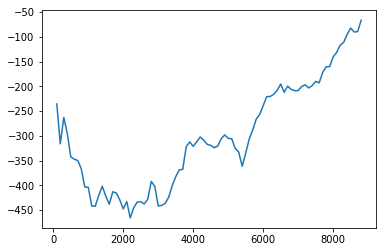

In [21]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(), key=lambda p:p[0]))
plt.plot(iters, ewma(np.array(session_rewards),span=10))

In [22]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-11-04 20:14:05,022] Making new env: LunarLander-v2
[2017-11-04 20:14:05,031] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 20:14:05,034] Starting new video recorder writing to /Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records/openaigym.video.89.14424.video000000.mp4

[2017-11-04 20:14:09,050] Starting new video recorder writing to /Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records/openaigym.video.89.14424.video000001.mp4



Episode finished after 349 timesteps with reward=-70.97850949288203
Episode finished after 191 timesteps with reward=-83.15826404669065
Episode finished after 828 timesteps with reward=126.82024217692084


 88%|████████▊ | 8799/10000 [14:30<01:58, 10.11it/s]

Episode finished after 892 timesteps with reward=-229.50756910689572
Episode finished after 295 timesteps with reward=-55.58657579710053
Episode finished after 506 timesteps with reward=-117.01362527358472
Episode finished after 341 timesteps with reward=-137.79148384314334


[2017-11-04 20:14:17,031] Starting new video recorder writing to /Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records/openaigym.video.89.14424.video000008.mp4



Episode finished after 1000 timesteps with reward=-104.53073442813191


[2017-11-04 20:14:20,905] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maxim/code/git/ATP_ML/HW/sem_2/HW_5_RL_LunarLander/records')


Episode finished after 320 timesteps with reward=-59.091398453883116
Episode finished after 224 timesteps with reward=-62.418196828448
average reward: [-70.978509492882026, -83.158264046690647, 126.82024217692084, -229.50756910689572, -55.586575797100529, -117.01362527358472, -137.79148384314334, -104.53073442813191, -59.091398453883116, -62.418196828448004]
